<a href="https://colab.research.google.com/github/BethwelKimutai/Ai_assistant2/blob/main/AcousticModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Install dependencies
Ensure all required libraries, including `g2p-en`, are installed.


In [1]:
!pip install g2p-en torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=198c9d95a7a317477bfe0bf93616dcaeb31dde6899b2c691b9bb3d85cad07002
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


# Cell 2: Load the LibriSpeech dataset
This cell downloads and loads the `train-clean-100` subset of the LibriSpeech dataset.


In [2]:
import torchaudio

# Load the LibriSpeech dataset
dataset = torchaudio.datasets.LIBRISPEECH(".", url="train-clean-100", download=True)

# Access an example sample
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]
print(f"Waveform shape: {waveform.shape}")
print(f"Transcript: {transcript}")



100%|██████████| 5.95G/5.95G [04:48<00:00, 22.2MB/s]


Waveform shape: torch.Size([1, 225360])
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK


# Cell 3: Define character and phoneme vocabularies
This cell uses the `g2p-en` library for phoneme tokenization.


In [3]:
import nltk


In [4]:
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [5]:
from g2p_en import G2p

# Initialize g2p
g2p = G2p()

# Character-level vocabulary
char_vocab = {c: i for i, c in enumerate("abcdefghijklmnopqrstuvwxyz '")}
char_vocab["<blank>"] = len(char_vocab)  # Add blank token for CTC Loss

# Phoneme-level vocabulary
phoneme_vocab = {"<blank>": 0}
sample_text = "abcdefghijklmnopqrstuvwxyz"
for phoneme in set(g2p(sample_text)):
    phoneme_vocab[phoneme] = len(phoneme_vocab)

# Tokenizers
def char_tokenizer(text):
    return list(text.lower())

def phoneme_tokenizer(text):
    return g2p(text)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


# Cell 4: Create a custom dataset class
This wraps the dataset to tokenize transcripts and preprocess data for model training.


In [16]:
from torch.utils.data import Dataset, DataLoader
import torch

class CommonVoiceDataset(Dataset):
    def __init__(self, dataset, vocab, tokenizer):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Adjust to match the structure of your dataset
        # If dataset returns only (waveform, transcript), adjust as follows:
        try:
            waveform, transcript = self.dataset[idx]  # Ensure it matches your dataset's return
        except ValueError:
            raise ValueError("Ensure your dataset returns (waveform, transcript). Adjust as needed.")

        # Tokenize transcript
        tokens = self.tokenizer(transcript)
        target = [self.vocab[token] for token in tokens if token in self.vocab]

        return waveform, torch.tensor(target, dtype=torch.long)


Waveform: tensor([-1.2102,  0.3401,  0.1253,  ..., -0.8486,  0.0161,  0.4724])
Tokens: ['hello', 'world']
Target (indices): [1, 2]


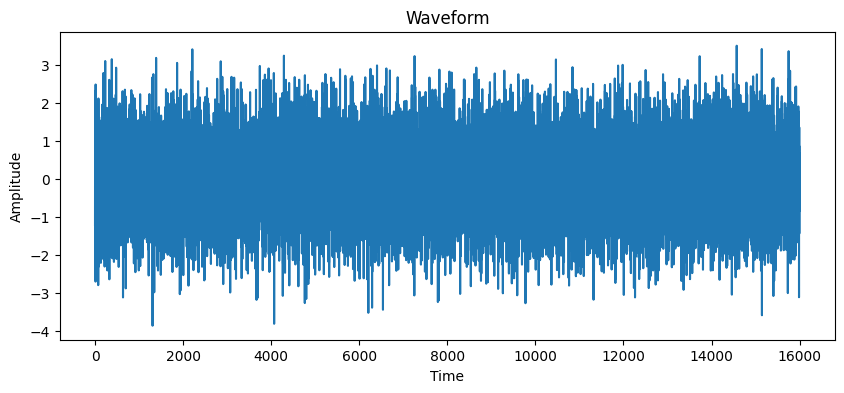

In [19]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

# Define a simple tokenizer for demonstration
def tokenizer(text):
    return text.lower().split()  # Tokenizes the transcript into lowercase words

# Define a mock vocab for demonstration
vocab = {word: idx for idx, word in enumerate(["<blank>", "hello", "world", "test"])}

# Mock dataset structure for demonstration
class MockDataset:
    def __getitem__(self, idx):
        # Replace these with actual data fetching logic
        waveform = torch.randn(16000)  # Simulating a 1-second audio waveform (16 kHz)
        sample_rate = 16000  # Example sample rate
        transcript = "hello world"  # Example transcript
        return waveform, sample_rate, transcript

    def __len__(self):
        return 10  # Example dataset size

# Replace `MockDataset` with your actual dataset
mock_dataset = MockDataset()

# Custom CommonVoiceDataset implementation
class CommonVoiceDataset(Dataset):
    def __init__(self, dataset, vocab, tokenizer):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, transcript = self.dataset[idx]
        tokens = self.tokenizer(transcript)
        target = [self.vocab[token] for token in tokens if token in self.vocab]
        return waveform, torch.tensor(target, dtype=torch.long), transcript

# Create the CommonVoiceDataset instance
common_voice_dataset = CommonVoiceDataset(
    dataset=mock_dataset,
    vocab=vocab,
    tokenizer=tokenizer
)

# Choose an index to inspect
index = 0  # Replace with any valid index
waveform, target, transcript = common_voice_dataset[index]

# Convert target indices back to tokens for easier understanding
tokens = [token for token in tokenizer(transcript) if token in vocab]

# Print the waveform, tokens, and target
print(f"Waveform: {waveform}")
print(f"Tokens: {tokens}")
print(f"Target (indices): {target.tolist()}")

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.numpy())
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


# Cell 5: Define a custom collate function
This function handles variable-length inputs by padding them, enabling batch processing.


In [11]:
def collate_fn(batch):
    waveforms, targets = zip(*batch)

    # Pad waveforms
    max_len_wave = max([waveform.size(0) for waveform in waveforms])
    padded_waveforms = torch.zeros(len(waveforms), 1, max_len_wave)
    for i, waveform in enumerate(waveforms):
        padded_waveforms[i, 0, :waveform.size(0)] = waveform

    # Pad targets
    max_len_target = max([len(target) for target in targets])
    padded_targets = torch.zeros(len(targets), max_len_target, dtype=torch.long)
    target_lengths = torch.zeros(len(targets), dtype=torch.long)

    for i, target in enumerate(targets):
        padded_targets[i, :len(target)] = target
        target_lengths[i] = len(target)

    return padded_waveforms, padded_targets, target_lengths


In [22]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming CommonVoiceDataset and collate_fn are already defined

# Create the dataset and DataLoader
batch_size = 16
dataset = CommonVoiceDataset(dataset, vocab, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

# Retrieve one batch
for i, (waveforms, targets, target_lengths) in enumerate(data_loader):
    print(f"Batch {i + 1}")
    print(f"Waveforms shape: {waveforms.shape}")  # [batch_size, 1, max_len_wave]
    print(f"Targets shape: {targets.shape}")      # [batch_size, max_len_target]
    print(f"Target lengths: {target_lengths}")   # Lengths of each target sequence

    # Plot the first waveform in the batch
    plt.figure(figsize=(10, 4))
    plt.plot(waveforms[0, 0].numpy())  # Plot the first waveform
    plt.title(f"Waveform of First Sample in Batch {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # Print first sample details
    print(f"First waveform (shape): {waveforms[0].shape}")
    print(f"First target (indices): {targets[0].tolist()}")
    print(f"First target length: {target_lengths[0]}")

    break  # Break after the first batch for inspection


ValueError: not enough values to unpack (expected at least 3, got 2)

# Cell 6: Apply MFCC transformations
This cell extracts MFCC features from the audio waveforms.


In [14]:
import torchaudio.transforms as T

transform = T.MFCC(sample_rate=16000, n_mfcc=40, log_mels=True)

# Test transformation
sample_waveform, _ = dataset[0][0:2]
mfcc_features = transform(sample_waveform)
print(mfcc_features.shape)


torch.Size([1, 40, 1127])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


# Cell 7: Define the acoustic model
The model maps MFCC features to potential phoneme sequences.


In [15]:
import torch.nn as nn

class AcousticModel(nn.Module):
    def __init__(self, vocab_size):
        super(AcousticModel, self).__init__()
        self.cnn = nn.Conv1d(40, 128, kernel_size=5, stride=1, padding=2)  # Input: 40 channels (MFCC features)
        self.rnn = nn.LSTM(128, 256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256 * 2, vocab_size)  # Output: vocab_size logits per time step

    def forward(self, x):
        x = self.cnn(x)              # Shape: [batch_size, 128, time_steps]
        x = x.permute(0, 2, 1)       # Shape: [batch_size, time_steps, 128] (for RNN)
        x, _ = self.rnn(x)           # Shape: [batch_size, time_steps, 512] (bidirectional RNN)
        x = self.fc(x)               # Shape: [batch_size, time_steps, vocab_size]
        return x

# Cell 8: Train the model
This cell implements the training loop with CTC loss.


In [20]:
import torch
from torch.nn import CTCLoss
from torch.optim import Adam

# Assuming your model and transformation are already defined
model = AcousticModel(vocab_size=len(vocab))  # Replace with your model definition
criterion = CTCLoss(blank=vocab["<blank>"])  # CTC Loss
optimizer = Adam(model.parameters(), lr=0.001)  # Adam optimizer

def compute_loss(model, criterion, waveforms, targets, target_lengths, transform):
    """
    Compute the loss for a batch.
    """
    # Extract features
    features = transform(waveforms.squeeze(1))  # Remove the channel dimension

    # Log feature and waveform information
    print(f"Waveforms shape: {waveforms.shape}")  # [batch_size, channels, time]
    print(f"Features shape: {features.shape}")   # [batch_size, num_features, time_steps]

    # Forward pass
    outputs = model(features)  # Expecting [batch_size, time_steps, num_classes]

    # Correctly prepare input lengths for CTC Loss
    batch_size = features.size(0)  # Extract batch size
    time_steps = features.size(2)  # Extract time steps for each sample
    input_lengths = torch.full((batch_size,), time_steps, dtype=torch.long)

    print(f"Input lengths: {input_lengths}")  # Time steps for each sample in batch

    # Flatten targets for CTC Loss
    flat_targets = targets[targets != 0]

    # Log batch size
    print(f"Batch size: {waveforms.size(0)}")  # First dimension of waveforms

    # Compute the CTC Loss
    loss = criterion(
        log_probs=outputs.log_softmax(2),  # log probabilities of predictions
        targets=flat_targets,              # flattened actual target sequences
        input_lengths=input_lengths,       # length of each input sequence
        target_lengths=target_lengths      # length of each target sequence
    )
    return loss


In [21]:
def train_one_epoch(model, optimizer, criterion, data_loader, transform):
    """
    Train the model for one epoch and return the average loss.
    """
    model.train()
    epoch_loss = 0


    for waveforms, targets, target_lengths in data_loader:
        optimizer.zero_grad()
        loss = compute_loss(model, criterion, waveforms, targets, target_lengths, transform)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, optimizer, criterion, data_loader, transform)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

Waveforms shape: torch.Size([16, 1, 260720])
Features shape: torch.Size([16, 40, 1304])
Input lengths: tensor([1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304,
        1304, 1304, 1304, 1304])
Batch size: 16


RuntimeError: input_lengths must be of size batch_size